In [1]:
from stylelib import *
from process_helper import *

In [2]:
path = "/Users/scarlet/Desktop/"
paper_path = "revision/"
storage = "redis"
selectby = "median"
unit = "ms"

## 0. Select Color Scheme

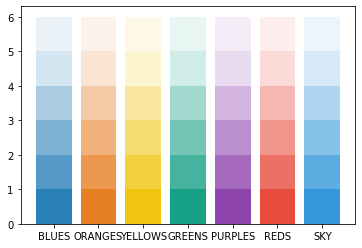

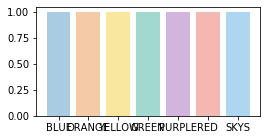

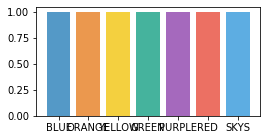

<Figure size 288x144 with 0 Axes>

In [3]:
_, grad_colors = display_colors()
_, bar_colors = select_color_idx(2)
_, line_colors = select_color_idx(4)

In [4]:
C_1PC

'ORANGE'

In [5]:
C_2PC

'BLUE'

In [7]:
plt.rcParams.update({'font.size': 18})
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.5

In [75]:
df["NUM_NODES"].unique()

array([2])

## 1. ELR - Contention

In [78]:
def process_throughput(x, df):
    if not isinstance(x, str):
        agg_throughput = df.groupby(['COMMIT_ALG', 'i'] + x, as_index=False)['Throughput'].max()
    else:
        # sum up throughput for each trial
        agg_throughput = df.groupby(['COMMIT_ALG', 'i', x], as_index=False)['Throughput'].max()
    # sum up throughput by number of nodes
    agg_throughput["Throughput"] = agg_throughput["Throughput"] * 2
    return agg_throughput

def process_latency(x, df, latency_type="dist_latency", select=None):
    # require agg_throughput to indicate trial id as trials are selected by max throughput
    # process the latency
    latency = []

    if select is not None:
        if not isinstance(x, str):
            select = select.set_index(["COMMIT_ALG"] + x)
        else:
            select = select.set_index(["COMMIT_ALG", x])
            
    if isinstance(x, str):
        for (alg, i, v), group in df.groupby(['COMMIT_ALG', 'i', x]):
            if select is not None:
                if select.loc[(alg, v), "i"] != i:
                    continue
            # calculate weighted sum for each column/attribute
            weight = WEIGHT[latency_type]
            record = {"COMMIT_ALG": alg, "i": i, x: v}
            for y in TYPE[latency_type]:
                if group[weight].sum() == 0:
                    print("[WARNING]: zero weight %s" % weight)
                    agg = np.nan
                    break
                agg = (group[y] * group[weight]).sum() / group[weight].sum()
                record[PREFIX+y] = agg
            if np.isnan(agg):
                continue
            latency.append(record)
    else:
        for tags, group in df.groupby(['COMMIT_ALG', 'i'] + x):
            alg = tags[0]
            i = tags[1]
            v = tags[2:]
            if select is not None:
                if select.loc[tuple([alg]+list(v)), "i"] != i:
                    continue
            # calculate weighted sum for each column/attribute
            weight = WEIGHT[latency_type]
            record = {"COMMIT_ALG": alg, "i": i}
            for kid, key in enumerate(x):
                record[key] = v[kid]
            for y in TYPE[latency_type]:
                if group[weight].sum() == 0:
                    print("[WARNING]: zero weight %s" % weight)
                    agg = np.nan
                    break
                agg = (group[y] * group[weight]).sum() / group[weight].sum()
                record[PREFIX+y] = agg
            if np.isnan(agg):
                continue
            latency.append(record)
    latency = pd.DataFrame(data=latency)
    return latency


def aggregate(x, df, latency_type="dist_latency", agg="latency", how="minmax"):
    # drop invalid data
    data = df.dropna(subset=y_agg_latency+["Throughput"], axis=0)
    data = data[data['Throughput'] != 0]
    throughput = process_throughput(x, data)
    latency = process_latency(x, data, latency_type=latency_type)
    if isinstance(x, str):
        select_cols = ['COMMIT_ALG', 'i', x]
        select_cols_noid = ['COMMIT_ALG', x]
    else:
        select_cols = ['COMMIT_ALG', 'i'] + x
        select_cols_noid = ['COMMIT_ALG'] + x
        
    if agg != "throughput":
        if how == "minmax":
            idx_max = latency.groupby(select_cols_noid)[PREFIX+TYPE[latency_type][0]].idxmin().values
            print("selected trial with min {}".format(PREFIX+TYPE[latency_type][0]))
        elif how == "median":
            agg_col = PREFIX+TYPE[latency_type][0]
            idx_max = []
            for name, group in latency.groupby(select_cols_noid):
                n = int(group.shape[0] / 2) - 1
                idx_max.append(group.sort_values(agg_col).index.values[n])
            print("selected trial with median {}".format(PREFIX+TYPE[latency_type][0]))
        agg_latency = latency.loc[idx_max]
        agg_throughput = throughput.loc[select(throughput, agg_latency, select_cols)]
    else:
        # select the trials with highest throughput
        idx_max = agg_throughput.groupby(select_cols_noid)['Throughput'].idxmax().values
        agg_throughput = agg_throughput.loc[idx_max]
        print("selected trial with max throughput")
        agg_latency = latency.loc[select(latency, agg_throughput, select_cols)]
    return agg_throughput, agg_latency

### 1.1 YCSB - Zipfian

In [79]:
exp = "%s_zipf_elr_redis"%storage
x = "ZIPF_THETA"
opt = "EARLY_LOCK_RELEASE"
opt_label = "ELR"
df = pd.read_csv(path+"ycsb_zipf_elr_new{}.csv".format(storage))
df = apply_mask(df, [("ZIPF_THETA", ["ne", 0.3])])
# agg: "latency" or "Throughput"
agg_throughput, agg_latency = aggregate([x, opt], df, latency_type="dist_latency", agg="latency", how="minmax")

selected trial with min AGG_average_dist_latency


In [38]:
agg_latency.groupby(["ZIPF_THETA", "COMMIT_ALG", "EARLY_LOCK_RELEASE"])["AGG_average_dist_latency"].sum()

ZIPF_THETA  COMMIT_ALG  EARLY_LOCK_RELEASE
0.00        ONE_PC      False                 0.006116
                        True                  0.006547
            TWO_PC      False                 0.011194
                        True                  0.009543
0.50        ONE_PC      False                 0.007196
                        True                  0.006657
            TWO_PC      False                 0.011083
                        True                  0.009645
0.90        ONE_PC      False                 0.057605
                        True                  0.021130
            TWO_PC      False                 0.066112
                        True                  0.023083
0.99        ONE_PC      False                 0.131298
                        True                  0.033739
            TWO_PC      False                 0.169553
                        True                  0.033761
Name: AGG_average_dist_latency, dtype: float64

In [39]:
agg_latency["COMMIT_ALG"] = ["{}-{}".format(alg, colocate) for alg, colocate in zip(agg_latency["COMMIT_ALG"], agg_latency["EARLY_LOCK_RELEASE"])]

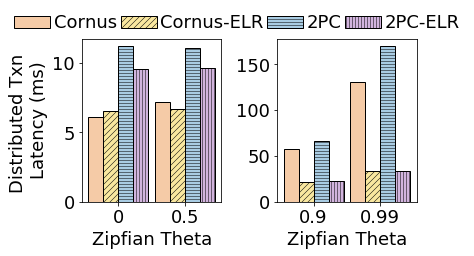

In [71]:
color_names = [C_1PC, "YELLOW", C_2PC, "PURPLE"]
color_patches = [bar_colors[c] for c in color_names]
color = [grad_colors[c+"S"] for c in color_names]
lcolor = [line_colors[C_1PC],line_colors[C_2PC]]
pattern = ALL_PATTERNS
scale = 1
if unit == "ms":
    scale = 1000
elif unit == "us":
    scale = 1000000
linestyle = ["-", "--"] # avg, tail

prefix="AGG_"
algcol = "COMMIT_ALG"
labels = ["Cornus", "Cornus-ELR", "2PC", "2PC-ELR"]
algs = ["ONE_PC-False", "ONE_PC-True", "TWO_PC-False", "TWO_PC-True"]

width = 0.9 / len(algs)
offset = np.arange(-0.45+0.5*width, 0.5, width)

fig, (ax, ax2) = plt.subplots(1, 2)
x = "ZIPF_THETA"
xvalues1 = [0, 0.5]
for xid, xv in enumerate(xvalues1):
    data = apply_mask(agg_latency, [(x, xv)])
    for idx, alg in enumerate(algs):
        plot_data = apply_mask(data, [(algcol, alg)])
        for yid, y in enumerate(["average_dist_latency"]):
            v = plot_data[PREFIX + y].values * scale
            p = ax.bar(xid + offset[idx], v, bottom=0, width=width, 
                       color=color[idx][2], hatch=pattern[idx], edgecolor='black')
xvalues2 = [0.9, 0.99]
for xid, xv in enumerate(xvalues2):
    data = apply_mask(agg_latency, [(x, xv)])
    for idx, alg in enumerate(algs):
        plot_data = apply_mask(data, [(algcol, alg)])
        for yid, y in enumerate(["average_dist_latency"]):
            v = plot_data[PREFIX + y].values * scale
            p = ax2.bar(xid + offset[idx], v, bottom=0, width=width, 
                       color=color[idx][2], hatch=pattern[idx], edgecolor='black')
ax.set_xticklabels([""] + xvalues1)
ax2.set_xticklabels([""] + xvalues2)
ax.set_xlabel("Zipfian Theta")
ax2.set_xlabel("Zipfian Theta")
ax.legend(labels, loc="upper left", bbox_to_anchor=((-0.6,1.25)), ncol=4, frameon=False,
                     prop={'size': 18}, columnspacing=0.2, handletextpad=0.2)
ax.set_ylabel("Distributed Txn \nLatency (%s)"%unit)
fig.set_size_inches(6, 3)
plt.subplots_adjust(wspace=0.4)
plt.savefig(paper_path+exp+"({}_latency).pdf".format(selectby), bbox_inches="tight")

In [82]:
agg_throughput["COMMIT_ALG"] = ["{}-{}".format(alg, colocate) for alg, colocate in zip(agg_throughput["COMMIT_ALG"], agg_throughput["EARLY_LOCK_RELEASE"])]

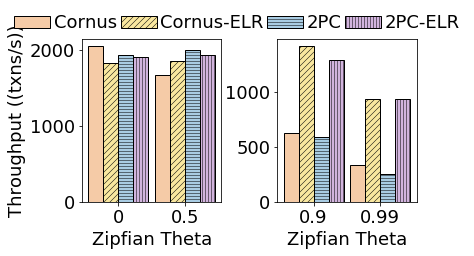

In [83]:
color_names = [C_1PC, "YELLOW", C_2PC, "PURPLE"]
color_patches = [bar_colors[c] for c in color_names]
color = [grad_colors[c+"S"] for c in color_names]
lcolor = [line_colors[C_1PC],line_colors[C_2PC]]
pattern = ALL_PATTERNS
scale = 1
linestyle = ["-", "--"] # avg, tail

prefix="AGG_"
algcol = "COMMIT_ALG"
labels = ["Cornus", "Cornus-ELR", "2PC", "2PC-ELR"]
algs = ["ONE_PC-False", "ONE_PC-True", "TWO_PC-False", "TWO_PC-True"]

width = 0.9 / len(algs)
offset = np.arange(-0.45+0.5*width, 0.5, width)

fig, (ax, ax2) = plt.subplots(1, 2)
x = "ZIPF_THETA"
xvalues1 = [0, 0.5]
for xid, xv in enumerate(xvalues1):
    data = apply_mask(agg_throughput, [(x, xv)])
    for idx, alg in enumerate(algs):
        plot_data = apply_mask(data, [(algcol, alg)])
        for yid, y in enumerate(["Throughput"]):
            v = plot_data[ y].values * scale
            p = ax.bar(xid + offset[idx], v, bottom=0, width=width, 
                       color=color[idx][2], hatch=pattern[idx], edgecolor='black')
xvalues2 = [0.9, 0.99]
for xid, xv in enumerate(xvalues2):
    data = apply_mask(agg_throughput, [(x, xv)])
    for idx, alg in enumerate(algs):
        plot_data = apply_mask(data, [(algcol, alg)])
        for yid, y in enumerate(["Throughput"]):
            v = plot_data[ y].values * scale
            p = ax2.bar(xid + offset[idx], v, bottom=0, width=width, 
                       color=color[idx][2], hatch=pattern[idx], edgecolor='black')
ax.set_xticklabels([""] + xvalues1)
ax2.set_xticklabels([""] + xvalues2)
ax.set_xlabel("Zipfian Theta")
ax2.set_xlabel("Zipfian Theta")
ax.legend(labels, loc="upper left", bbox_to_anchor=((-0.6,1.25)), ncol=4, frameon=False,
                     prop={'size': 18}, columnspacing=0.2, handletextpad=0.2)
ax.set_ylabel("Throughput ((txns/s))")
fig.set_size_inches(6, 3)
plt.subplots_adjust(wspace=0.4)
plt.savefig(paper_path+exp+"({}_throughput).pdf".format(selectby), bbox_inches="tight")

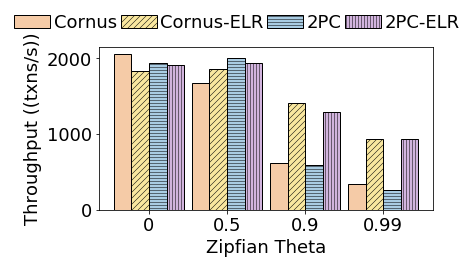

In [86]:
color_names = [C_1PC, "YELLOW", C_2PC, "PURPLE"]
color_patches = [bar_colors[c] for c in color_names]
color = [grad_colors[c+"S"] for c in color_names]
lcolor = [line_colors[C_1PC],line_colors[C_2PC]]
pattern = ALL_PATTERNS
scale = 1
linestyle = ["-", "--"] # avg, tail

prefix="AGG_"
algcol = "COMMIT_ALG"
labels = ["Cornus", "Cornus-ELR", "2PC", "2PC-ELR"]
algs = ["ONE_PC-False", "ONE_PC-True", "TWO_PC-False", "TWO_PC-True"]

width = 0.9 / len(algs)
offset = np.arange(-0.45+0.5*width, 0.5, width)

fig, ax = plt.subplots()
x = "ZIPF_THETA"
xvalues1 = [0, 0.5, 0.9, 0.99]
for xid, xv in enumerate(xvalues1):
    data = apply_mask(agg_throughput, [(x, xv)])
    for idx, alg in enumerate(algs):
        plot_data = apply_mask(data, [(algcol, alg)])
        for yid, y in enumerate(["Throughput"]):
            v = plot_data[ y].values * scale
            p = ax.bar(xid + offset[idx], v, bottom=0, width=width, 
                       color=color[idx][2], hatch=pattern[idx], edgecolor='black')
ax.set_xticklabels([""] + xvalues1)
ax.set_xlabel("Zipfian Theta")
ax.legend(labels, loc="upper left", bbox_to_anchor=((-0.3,1.3)), ncol=4, frameon=False,
                     prop={'size': 18}, columnspacing=0.2, handletextpad=0.2)
ax.set_ylabel("Throughput ((txns/s))")
fig.set_size_inches(6, 3)
plt.subplots_adjust(wspace=0.4)
plt.savefig(paper_path+exp+"({}_throughput).pdf".format(selectby), bbox_inches="tight")

In [80]:
agg_throughput.groupby(["ZIPF_THETA", "COMMIT_ALG"])["Throughput"].max()

ZIPF_THETA  COMMIT_ALG
0.00        ONE_PC        2048.520
            TWO_PC        1939.898
0.50        ONE_PC        1859.114
            TWO_PC        2003.560
0.90        ONE_PC        1413.450
            TWO_PC        1290.704
0.99        ONE_PC         933.296
            TWO_PC         935.778
Name: Throughput, dtype: float64